In [1]:
import jax
from cft import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
import optax
from jax import jit, vmap, lax, grad, jacfwd

from functools import partial

from scipy import optimize

jax.config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=20)

from matplotlib.pyplot import cm

In [1324]:
def boots(beta,c, params, opt_fn, opt_state, steps=100):
    """ finds deltas

        Params:
        beta - random point for beta
        c - central charge
        deltas - intitialised deltas
        opt_fn - optimization function e.g. Adam
        opt_state - initial state

        Returns:
        losses, deltas, state

    """
#     @jit
    def loss_function(params):
        identy = vmap(reduced_partition_function_spinless, in_axes=(None, 0, None), out_axes=0)(params, beta, c)
        transformed = vmap(reduced_partition_function_spinless, in_axes=(None, 0, None), out_axes=0)(params, 1/beta, c)
#         print(identy.shape)
        return jnp.mean((identy-transformed)**2) # mean squared loss

    losses = []
    for _ in tqdm(range(steps)):
        # loss and gradients calulated with 
        loss, grads = jax.value_and_grad(loss_function)(params) 
        updates, opt_state = opt_fn(grads, opt_state)
        params += updates
        losses.append(loss) 

    return jnp.stack(losses), params, opt_state


100%|████████████████████████████████████████| 800/800 [00:06<00:00, 116.38it/s]


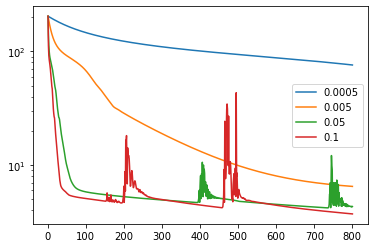

In [1332]:
number_delta = 10
rng = random.PRNGKey(12)
keys = random.split(rng, 2)
batch_size = 128
params = random.uniform(keys[1], (batch_size, 2, number_delta))*2
beta_size = 2*number_delta
beta = (random.uniform(keys[0], (beta_size,)) + 1/2 )
c = 4
step=800

# test for different learning rates
for lr in [5e-4 ,5e-3, 5e-2, 0.1]:
    adam = optax.adam(learning_rate=lr)
#     params = random.uniform(keys[1], (2, number_delta))*2
    params = random.uniform(keys[1], (batch_size, 2, 10))*2
    losses, params, _ = boots(beta, c, params, opt_fn=adam.update, opt_state=adam.init(params),steps=step)
    steps = np.linspace(1,step,step)
    plt.plot(steps,losses,label=f"{lr}")
    plt.yscale("log")
    plt.legend()

    # print(learned_deltas)

In [1333]:
params.shape

(128, 2, 10)

In [1335]:
jnp.sort(params)

DeviceArray([[[ 0.37861199,  0.37862294,  0.83809272, ...,  0.9152998 ,
                0.91793441,  0.9403382 ],
              [ 0.37860556,  0.8097835 ,  0.91130832, ...,  0.91613582,
                0.91669292,  2.07845667]],

             [[ 0.34025298,  7.33085342,  7.54149412, ..., 12.54906638,
               14.77312594, 16.47673069],
              [ 0.34499449,  5.87408497,  7.90694758, ..., 12.59748878,
               13.06718227, 14.87715586]],

             [[ 0.06371786,  0.18590958,  0.33128305, ...,  1.43608001,
                1.44248092,  1.62621345],
              [ 0.12126838,  0.44449996,  0.598009  , ...,  1.62174401,
                1.63637134,  1.78587965]],

             ...,

             [[ 0.06848676,  0.08964665,  0.33792242, ...,  1.49667898,
                1.76248279,  1.82130552],
              [ 0.09261414,  1.01789018,  1.11071099, ...,  1.25261273,
                1.51837084,  1.6275978 ]],

             [[ 0.17539854,  0.24987877,  0.37545894, ...,  1

In [78]:
batch_size = 128
rng = random.PRNGKey(12)
keys = random.split(rng, 2)
beta = (random.uniform(keys[0], (batch_size,)) + 1/2 )
# params = random.uniform(keys[1], (batch_size, 2, 10))*2

step=100000
lr = 0.00005
# params = random.uniform(keys[1], (batch_size, 2, 6))*10

for epoch in range(1):
    key_n, *keys = random.split(key_n, 3)
    # beta = (random.uniform(keys[0], (batch_size,)) + 1/2 )
    c = 3.5
    adam = optax.adam(learning_rate=lr)
    # if epoch > 2:
    # lr = lr/10
    losses, params, _ = boots(beta, c, params, opt_fn=adam.update, opt_state=adam.init(params),steps=step)
    steps = np.linspace(epoch*step+1,(epoch+1)*step,step)
    plt.plot(steps,losses)
    plt.yscale("log")


  5%|▍         | 4521/100000 [00:15<05:24, 294.38it/s]


KeyboardInterrupt: 

## Random Rough stuff beyond this point

In [95]:
@jit
def loss_function(params, beta, c):
        identy = vmap(reduced_partition_function_spinless, in_axes=(0,0,None), out_axes=0)(params, beta, c)
        transformed = vmap(reduced_partition_function_spinless, in_axes=(0,0, None), out_axes=0)(params, 1/beta, c)
        return jnp.mean((identy-transformed)**2) # mean squared loss


## Using Scipy optimizers

In [46]:
from jaxopt import ScipyRootFinding
from scipy import optimize

(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)


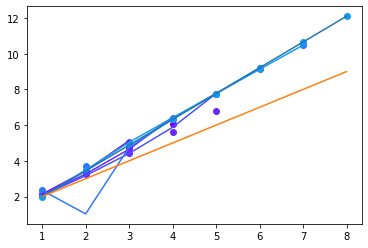

In [1265]:
laguerre_deltas = vmap(laguerre_at_x, in_axes = (None, 0), out_axes=1)
amus = jnp.ones(3, dtype=float)*1
deltas = jnp.array([ 2.13,  3.43,  5.12])
params = jnp.array([deltas,
              amus])
color = iter(cm.rainbow(np.linspace(0, 1, 20)))
c = 12
x = -(c-1)/12

@jit
def primal(params):
    deltas = params[0]
    rhos = params[1]
    deltas = deltas + x
    l = len(params[0])*2
    lps = laguerre_deltas(l-1,deltas)
#     maxl = jnp.max(jnp.abs(lps), axis=0)
#     lps = lps/maxl
    lp0 = laguerre_at_0(l-1, x)
    rho_lps = jnp.sum(rhos * lps, axis = 1)
    crossing_equation = (1 + rho_lps/lp0)
    return  crossing_equation

list_params = []
list_losses = []

for p in range(4,9):
    col = next(color)
    solver = ScipyRootFinding(method='hybr', jit=True, optimality_fun=primal)
    res = solver.run(params)
    list_losses.append(primal(res.params))

    deltas = res.params[0]
    list_params.append(res.params)
    
    x_ind = jnp.arange(1,p, dtype= float)
    plt.plot(x_ind,deltas, color=col)
    
    r = 1
    if p> 5:
        r = 4
    amus = jnp.ones(p, dtype=float)*1
    scale = (deltas[r] - deltas[0])/(r)
    new_deltas = scale * (jnp.arange(p)) + deltas[0]
    
    # d = jnp.linspace(1.0,p,(p-1)*100)
    # dp = (jnp.arange(1, p, dtype = float) - 1) *scale + 1
    # fp = (deltas - deltas[0])*scale + deltas[0]
    # y_ = jnp.interp(d,dp,fp)
    # new_deltas = y_[::rate]
   
    xx = jnp.arange(1,p+1, dtype= float)

    # plt.plot(d,y_)
#     plt.plot(xx,new_deltas)
    
    x_ind = jnp.arange(1,p+1, dtype= float)
    plt.scatter(x_ind,new_deltas, color = col)
    
    params = jnp.array([new_deltas,amus])

    print(params.shape)
    


plt.plot(xx,new_deltas)
plt.plot(xx, 1 + xx)

In [1511]:
list_params

[DeviceArray([2.1317e+00, 3.4346e+00, 5.1289e+00, 7.2654e-01, 6.9311e-02,
              5.5533e-04], dtype=float64),
 DeviceArray([2.0811e+00, 3.2639e+00, 4.6514e+00, 6.4502e+00, 7.1628e-01,
              9.3342e-02, 2.0470e-03, 5.0207e-06], dtype=float64),
 DeviceArray([2.0524e+00, 3.1700e+00, 4.4146e+00, 5.8786e+00, 7.7691e+00,
              7.0774e-01, 1.0843e-01, 3.7741e-03, 3.1295e-05, 3.0565e-08],            dtype=float64),
 DeviceArray([2.0350e+00, 3.1137e+00, 4.2771e+00, 5.5803e+00, 7.1134e+00,
              9.0862e+00, 7.0156e-01, 1.1793e-01, 5.3012e-03, 7.8741e-05,
              3.0831e-07, 1.4004e-10], dtype=float64),
 DeviceArray([2.0241e+00, 3.0782e+00, 4.1910e+00, 5.3998e+00, 6.7577e+00,
              8.3541e+00, 1.0402e+01, 6.9724e-01, 1.2403e-01, 6.5096e-03,
              1.3541e-04, 1.0492e-06, 2.2043e-09, 5.1659e-13],            dtype=float64),
 DeviceArray([2.0169e+00, 3.0549e+00, 4.1346e+00, 5.2828e+00, 6.5355e+00,
              7.9447e+00, 9.5994e+00, 1.1716e+01, 6

In [1262]:
list_losses

[DeviceArray([  1.        ,   1.        ,   0.99999995,   0.99999887,
                0.99997976,   0.99971997,   0.99699679,   0.97487917,
                0.83540544,   0.1537606 ,  -2.40988261,  -9.71681222,
              -25.02235022, -47.031585  , -64.58581308, -62.16052018,
              -37.93276363, -10.56730566], dtype=float64)]

In [931]:
amus = jnp.ones(3, dtype=float)*10000
deltas = jnp.array([ 2.13,  3.33,  5.13])
params = jnp.array([deltas,amus])

deltas = params[0]
rhos = params[1]
deltas = deltas + x
l = len(params[0])*2
lps = laguerre_deltas(l-1,deltas)
maxl = jnp.max(jnp.abs(lps), axis=0)
lps = lps/maxl
lp0 = laguerre_at_0(l-1, x)
rho_lps = jnp.sum(rhos * lps, axis = 1)
crossing_equation = (1 + rho_lps/lp0)


## Using newton-raphson

In [2]:
laguerre_deltas = vmap(laguerre_at_x, in_axes = (None, 0), out_axes=1)

c = 12
x = -(c-1)/12

@jit
def primal(params):
    h = len(params)//2
    deltas = lax.dynamic_slice(params, (0,),(h,))
    rhos = lax.dynamic_slice(params, (h,),(h,))
    deltas = deltas + x
    lps = laguerre_deltas(2*h -1,deltas)
#     maxl = jnp.max(jnp.abs(lps), axis=0)
#     lps = lps/maxl
    lp0 = laguerre_at_0(2*h-1, x)
    rho_lps = jnp.sum(rhos * lps, axis = 1)
    crossing_equation = (1 + rho_lps/lp0)
    return  crossing_equation

@jit
def nr_primal(x0, tol=1e-10, max_iter=2000):
    """
    Finds a solution to a system of nonlinear equations using the Newton-Raphson method.

    Args:
        f (function): A function that takes a vector x and returns a vector of the same length.
        x0 (array): Initial guess for the solution vector.
        tol (float): Tolerance for the norm of the residual vector. Default is 1e-6.
        max_iter (int): Maximum number of iterations. Default is 100.

    Returns:
        x (array): Solution vector.
    """

    f = primal

    Jf = jit(jacfwd(f))

    @jit
    def newton_step(val):
        x, r, n, _ = val
        n = n + 1
        J = Jf(x)
        r = f(x)
        dx = jnp.linalg.solve(J, -r)
        x1 = x + dx
        abort = jnp.any(jnp.isnan(x1))
        return (jnp.where(abort, x, x1), r , n, abort)
    
    def cond(val):
        x, r, n, abort = val
        return (~abort) & (jnp.max(jnp.abs(r)) > tol) & ( n< max_iter)

    
    return  lax.while_loop(cond, newton_step, (x0, jnp.ones(x0.shape), 0.0, False))

In [143]:
@jit
def primal_normal(params):
    h = len(params)//2
    deltas = lax.dynamic_slice(params, (0,),(h,))
    rhos = lax.dynamic_slice(params, (h,),(h,))
    deltas = deltas + x
    lps = laguerre_deltas(2*h -1,deltas)
    maxl = jnp.max(jnp.abs(lps), axis=0)
    lps = lps/maxl
    lp0 = laguerre_at_0(2*h-1, x)
    rho_lps = jnp.sum(rhos * lps, axis = 1)
    crossing_equation = (1 + rho_lps/lp0)
    return  crossing_equation



@jit
def nr_primal_normal(x0, tol=1e-7, max_iter=10000):
    """
    Finds a solution to a system of nonlinear equations using the Newton-Raphson method.

    Args:
        f (function): A function that takes a vector x and returns a vector of the same length.
        x0 (array): Initial guess for the solution vector.
        tol (float): Tolerance for the norm of the residual vector. Default is 1e-6.
        max_iter (int): Maximum number of iterations. Default is 100.

    Returns:
        x (array): Solution vector.
    """

    f = primal_normal
    Jf = jit(jacfwd(f))

    @jit
    def newton_step(val):
        x, r, n, _ = val
        n = n + 1
        J = Jf(x)
        r = f(x)
        dx = jnp.linalg.solve(J, -r)
        x1 = x + dx
        abort = jnp.any(jnp.isnan(x1))
        return (jnp.where(abort, x, x1), r , n, abort)
    
    def cond(val):
        x, r, n, abort = val
        return ( ~abort) & (jnp.max(jnp.abs(r)) > tol) & ( n< max_iter) 

    return  lax.while_loop(cond, newton_step, (x0, jnp.ones(x0.shape), 0.0, False))

[ 5.4134279338466360e+137  1.7114621232571491e+099
  2.1316272704546278e+118  2.0975105967508458e+054
  2.5127467471413652e+005 -3.0561388898143645e+013
 -2.5379439009827586e+061  6.6468848835707851e+076
 -1.5328268384867627e+082]


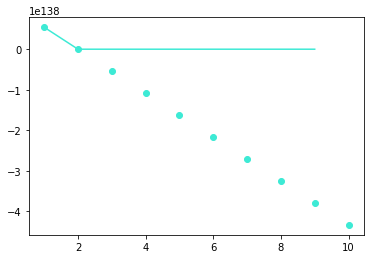

In [151]:
param_ = jnp.array([ 2.0120404550857076e+00, 3.0392491923626603e+00,
              4.0965561547156177e+00, 5.2037799304975634e+00,
              6.3873114412628693e+00, 7.6822445932447554e+00,
              9.1394981550072174e+00, 1.0848360167089290e+01,
              1.3028786422743138e+01,
  1.              ,    1.       ,           1.,
  1.             ,     1.      ,            1.,
  1.             ,     1.      ,            1.             ,     ])

params, *others = nr_primal( x0 = param_ )

p = 10
r = 1
h = len(params)//2
deltas = lax.dynamic_slice(params, (0,),(h,))

print(deltas)
x_ind = jnp.arange(1,p, dtype= float)
plt.plot(x_ind,deltas, color=col)

amus = jnp.ones(p, dtype=float)*k
scale = (deltas[r] - deltas[0])/(r)

new_deltas = scale * (jnp.arange(p)) + deltas[0]             
keys = random.split(keys[1],2)

x_ind = jnp.arange(1,p+1, dtype= float)
plt.scatter(x_ind,new_deltas, color = col)
params = jnp.array([new_deltas,amus]).flatten()

number of deltas = 3
number of deltas = 4
number of deltas = 5
number of deltas = 6
number of deltas = 7
number of deltas = 8
number of deltas = 9
number of deltas = 10
nan found delta 10
guess
[ 2.017249300339194   3.3927607513883506  4.768198752960007
  6.143808457268086   7.525190136057094   8.90699613953484
 10.283048916437501  11.657384618497105  13.032702658534825
 14.41516791424       1.                  1.
  1.                  1.                  1.
  1.                  1.                  1.
  1.                  1.                ]
params
[-2.1646184099173912e+01  5.4498129776367969e+13  1.2629199350631425e+15
 -2.8604250007812175e+15 -5.2550574565010540e+15 -1.2939662275980162e+16
 -3.8468491782079416e+16 -1.1508962036608955e+17 -3.1061046881668992e+17
 -7.1648731854528166e+17  3.0895286329268856e-11 -1.9375931312296709e+14
 -7.8524232586669500e+13 -1.4216750287196431e+14 -4.2163250017263438e+13
 -5.3097402310382627e+12 -3.7571855394323419e+11 -1.3410795560261265e+10
 -1.9

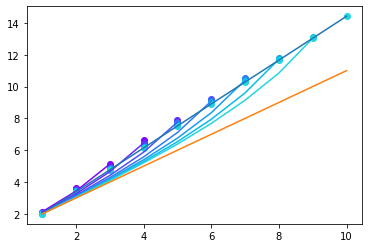

In [213]:
laguerre_deltas = vmap(laguerre_at_x, in_axes = (None, 0), out_axes=1)
color = iter(cm.rainbow(np.linspace(0, 1, 20)))

c = 12
x = -(c-1)/12

list_losses = []
list_params = []
list_guesses = []
deltas = jnp.array([2.12, 3.43, 5.13])
a_mus = jnp.ones(deltas.shape, dtype = float)*1
params = jnp.array([deltas,a_mus])
params = params.flatten()

list_guesses.append(params)
rng = random.PRNGKey(1)
keys = random.split(rng, 2)

for p in range(4,12):
    col = next(color)
    print(f"number of deltas = {p-1}")
    
    
    guess = params    
    params, *others = nr_primal(x0 = params)
        
        
    if others[2]:
        print(f"nan found delta {p-1}")
        print("guess")
        print(guess)
        print("params")
        print(params)
        break
        
    list_params.append(params)
    list_losses.append(primal(params))
    
    
    r = p-2
    k = 1
    
    h = len(params)//2
    deltas = lax.dynamic_slice(params, (0,),(h,))
    
    x_ind = jnp.arange(1,p, dtype= float)
    plt.plot(x_ind,deltas, color=col)
    
    amus = jnp.ones(p, dtype=float)*k
    scale = (deltas[r] - deltas[0])/(r)
    
    keys = random.split(keys[1],2)
    
    
    new_deltas = (scale * (jnp.arange(p)) + deltas[0] ) + random.uniform(keys[1], jnp.arange(p).shape) * 0.1/p    
    
   
    x_ind = jnp.arange(1,p+1, dtype= float)
    plt.scatter(x_ind,new_deltas, color = col)
    params = jnp.array([new_deltas,amus]).flatten()
    list_guesses.append(params)
    if p == 11:
        print("guess")
        print(params)

plt.plot(x_ind,new_deltas)
plt.plot(x_ind, 1 + x_ind)

In [1421]:
list_losses

[DeviceArray([-2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
              -6.66133815e-16, -1.55431223e-15, -2.44249065e-15],            dtype=float64),
 DeviceArray([ 1.11022302e-16,  3.33066907e-16,  8.88178420e-16,
               5.55111512e-16,  2.22044605e-16,  3.33066907e-16,
              -2.22044605e-16, -2.22044605e-16], dtype=float64),
 DeviceArray([ 1.11022302e-16, -2.22044605e-16, -8.88178420e-16,
              -6.66133815e-16, -2.22044605e-16, -2.22044605e-16,
              -2.22044605e-16, -1.11022302e-15, -2.66453526e-15,
              -3.99680289e-15], dtype=float64),
 DeviceArray([ 0.00000000e+00, -2.22044605e-16,  0.00000000e+00,
              -2.22044605e-16, -2.22044605e-16, -6.66133815e-16,
              -1.11022302e-15, -1.33226763e-15, -1.33226763e-15,
              -1.33226763e-15, -6.66133815e-16, -6.66133815e-16],            dtype=float64),
 DeviceArray([ 1.11022302e-16,  2.22044605e-16,  0.00000000e+00,
               1.11022302e-16,  1.11022302e-16, -2.

In [177]:
list_params

[DeviceArray([2.1317077922680436e+00, 3.4345579133998454e+00,
              5.1288629421203309e+00, 7.2653863900192672e-01,
              6.9310807635990318e-02, 5.5532667447074225e-04],            dtype=float64),
 DeviceArray([2.0811133956832402e+00, 3.2639281955913151e+00,
              4.6513903315237819e+00, 6.4502049247322848e+00,
              7.1628415647350008e-01, 9.3342091051700674e-02,
              2.0470462135811535e-03, 5.0206551839411923e-06],            dtype=float64),
 DeviceArray([2.0524040148793965e+00, 3.1700080874847241e+00,
              4.4146115985187446e+00, 5.8785778582483488e+00,
              7.7691247395614491e+00, 7.0774478356108439e-01,
              1.0843346313186764e-01, 3.7741037729852110e-03,
              3.1294760674281467e-05, 3.0565078062830900e-08],            dtype=float64),
 DeviceArray([2.0350381802830926e+00, 3.1137220531908305e+00,
              4.2770916146359808e+00, 5.5802827105955455e+00,
              7.1134024986546702e+00, 9.08616441

In [1423]:
list_guesses

[DeviceArray([2.12, 3.43, 5.13, 1.  , 1.  , 1.  ], dtype=float64),
 DeviceArray([2.13170779, 3.63028537, 5.12886294, 6.62744052, 1.        ,
              1.        , 1.        , 1.        ], dtype=float64),
 DeviceArray([2.0811134 , 3.53747724, 4.99384108, 6.45020492, 7.90656877,
              1.        , 1.        , 1.        , 1.        , 1.        ],            dtype=float64),
 DeviceArray([2.05240401, 3.4815842 , 4.91076438, 6.33994456, 7.76912474,
              9.19830492, 1.        , 1.        , 1.        , 1.        ,
              1.        , 1.        ], dtype=float64),
 DeviceArray([ 2.03503818,  3.44526343,  4.85548868,  6.26571392,
               7.67593917,  9.08616442, 10.49638967,  1.        ,
               1.        ,  1.        ,  1.        ,  1.        ,
               1.        ,  1.        ], dtype=float64),
 DeviceArray([ 2.02405389,  3.42031979,  4.81658568,  6.21285157,
               7.60911747,  9.00538336, 10.40164925, 11.79791515,
               1.        ,

In [217]:
def dilation(dnm1,dn, fixed_point = 1):
    lamda = (len(dn) - fixed_point)/(len(dnm1) - fixed_point)
    epsilon = jnp.log((dn[-1]-dn[fixed_point-1])/(dnm1[-1] - dnm1[fixed_point-1]))/jnp.log(lamda) 
    return epsilon
    

In [230]:
def guess_generator(dnm1, dn, fixed_point=1):
    epsilon = dilation(dnm1, dn, fixed_point)
    x_range = jnp.linspace(1.0,int(len(dn)),(int(len(dn))- 1)*50)
    x_discrete = jnp.arange(1, int(len(dn)) + 1, dtype = float)
    yn = jnp.interp(x_range, x_discrete, dn)
    lamda = (len(dn))/(len(dn) - 1)
    scale = lamda ** epsilon
    ynp1 = (yn - yn[0]) * scale + yn[0]
    sample_rate = int(49/ lamda)
    return ynp1[::sample_rate]

In [251]:
delta_9 = jnp.array([2.0120404550857076e+00, 3.0392491923626603e+00,
              4.0965561547156177e+00, 5.2037799304975634e+00,
              6.3873114412628693e+00, 7.6822445932447554e+00,
              9.1394981550072174e+00, 1.0848360167089290e+01,
              1.3028786422743138e+01])
delta_8 = jnp.array([2.0168682169115923e+00, 3.0549114254659542e+00,
              4.1346229456931107e+00, 5.2827826032482168e+00,
              6.5355287814747625e+00, 7.9447127641675204e+00,
              9.5993573904474587e+00, 1.1715801393523762e+01])

delta_10_g = guess_generator(delta_8, delta_9)

In [252]:
delta_10_g

DeviceArray([ 2.0120404550857076,  3.0029824030746606,
              4.018317608212593 ,  5.071051348505971 ,
              6.177488064176538 ,  7.357972267166592 ,
              8.638595251101338 , 10.054277143078906 ,
             11.702805810763287 , 13.752030067349533 ], dtype=float64)

In [176]:
deltas = jnp.array([2.0120404550857076,  3.0029824030746606,
              4.018317608212593 ,  5.071051348505971 ,
              6.177488064176538 ,  7.357972267166592 ,
              8.638595251101338 , 10.054277143078906 ,
             11.702805810763287 , 13.752030067349533])
deltas = deltas + random.uniform(keys[1], jnp.arange(10).shape) *0.031456
a_mus = jnp.ones(deltas.shape, dtype = float)*1e9
params = jnp.array([deltas,a_mus]).flatten() 

params, *others = nr_primal( x0 = params )
params

DeviceArray([ 4.2798757623374507e+02,  2.2512591641159845e+04,
              5.2692638073172616e+29,  8.5649498274126999e+58,
              2.6373908282620422e+58,  7.0232631362268895e+62,
             -5.9636073564312469e+62, -1.4854715108664540e+63,
             -1.0256882271445237e+64, -1.4866451734384411e+65,
              3.7247087709881592e+08,  8.8186153403426088e+14,
              3.9049358798055339e+40,  5.2034898023118011e+69,
             -2.0761597988872749e+67, -5.2353966669812862e+69,
              5.1763496665682994e+67,  8.9770417914920842e+65,
              8.4928360887714808e+63,  9.0349367041655676e+60],            dtype=float64)

r = []
for i in range(8):
    r.append(((i+3)/(i+2))**(1.0258644707202123) * d9[i] )

In [1112]:
r.insert(0, 2.01686822)

In [1114]:
r = jnp.array(r)

In [1115]:
r

DeviceArray([ 2.01686822,  3.05719604,  4.09166698,  5.17488971,
              6.33365651,  7.60486246,  9.04172544, 10.73606363,
             12.91139586], dtype=float64)

In [1285]:
deltas = jnp.array([2.01686822,  2.93667359,  3.88305476,  4.86644227,
              5.898588  ,  7.0086407 ,  8.2405561 ,  9.61948955,
             11.21606651])
a_mus = jnp.array([6.97237260e-01, 1.24032737e-01,
             6.50959708e-03, 1.35408156e-04, 1.04918931e-06,
             2.20434864e-09, 5.16590746e-13, 1e-15, 1e-15])
params = jnp.array([deltas,a_mus]).flatten()

params, *others = nr_primal( x0 = params )
params


DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan], dtype=float64)

In [1286]:
primal(params)

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan], dtype=float64)

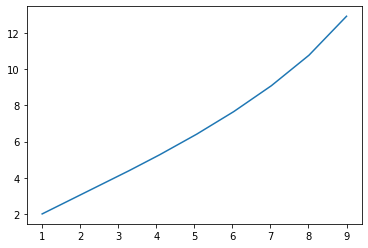

In [1134]:
d = jnp.linspace(1.0,9,(6)*100)
dp = jnp.arange(1, 10, dtype = float)
fp = jnp.array([ 2.01686822,  3.05719604,  4.09166698,  5.17488971,
              6.33365651,  7.60486246,  9.04172544, 10.73606363,
             12.91139586])
y_ = jnp.interp(d,dp,fp)
plt.plot(d,y_)
# d8 = y_[::99]
# y8 = y_
# plt.scatter(dp,d8)

In [1223]:
deltas = jnp.array([ 2.01686822,  2.93667359,  3.88305476,  4.86644227,
              5.898588  ,  7.0086407 ,  8.2405561 ,  9.61948955,
             11.21606651])
a_mus = jnp.ones(deltas.shape, dtype = float)*1e-10
params = jnp.array([deltas,a_mus]).flatten()
primal(params)

DeviceArray([ 9.99999995e-01,  9.99999840e-01,  9.99995200e-01,
              9.99887456e-01,  9.97976363e-01,  9.71997223e-01,
              6.99679037e-01, -1.51208257e+00, -1.54594562e+01,
             -8.36239400e+01, -3.39988261e+02, -1.07068122e+03,
             -2.60123502e+03, -4.80215850e+03, -6.55758131e+03,
             -6.31505202e+03, -3.89227636e+03, -1.15573057e+03],            dtype=float64)

In [1178]:
d = jnp.linspace(1.0,9,(6)*100)

In [1179]:
jnp.arange(1,7)/lamda

DeviceArray([0.85714286, 1.71428571, 2.57142857, 3.42857143, 4.28571429,
             5.14285714], dtype=float64, weak_type=True)

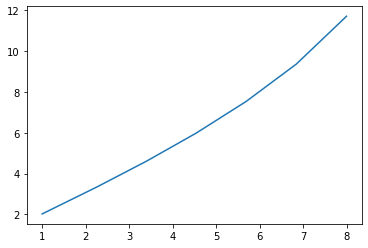

In [1204]:
(y8 - y8[0])* scale
d = jnp.linspace(1.0,8,(6)*100)
plt.plot(d,(y8 - y8[0])* scale + y8[0])

In [1202]:
y8_n = (y8 - y8[0])* scale + y8[0]


In [1205]:
600/7

85.71428571428571

In [1206]:
y8_n[::85]

DeviceArray([ 2.02405389,  3.06220012,  4.14805823,  5.30553737,
              6.56599534,  7.97424486,  9.60301346, 11.61954237],            dtype=float64)

In [1213]:
scale_x = (8/7)
scale_y = scale_x ** eps

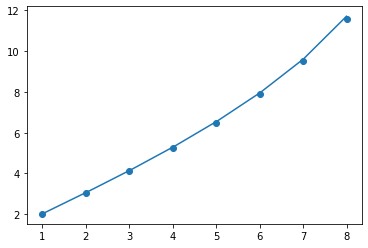

In [1211]:
d = jnp.linspace(1.0,8,(7)*100)
dp = jnp.arange(1, 9, dtype = float)
fp = jnp.array([2.01686822e+00, 3.05491143e+00, 4.13462295e+00,
             5.28278260e+00, 6.53552878e+00, 7.94471276e+00,
             9.59935739e+00, 1.17158014e+01])
y_ = jnp.interp(d,dp,fp)
plt.plot(d,y_)
d9 = y_[::99]
y9 = y_
plt.scatter(dp,d9)

In [1220]:
d = jnp.linspace(1.0,9,(7)*100)
y9_n = (y9 - y9[0])* scale_y + y9[0]
g = y9_n[::78]

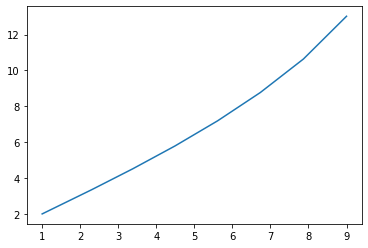

In [1217]:
700/9

77.77777777777777

DeviceArray([-9.73296119e+00, -1.75302675e+03, -1.39695534e+05,
             -5.40455679e+06, -1.26915638e+08, -1.85998221e+09],            dtype=float64)